In [1]:
import os
import pandas as pd
from datetime import datetime
from pyhealth.datasets import MIMIC3Dataset
from openai import OpenAI

import json
import tqdm as tqdm

In [2]:
from dotenv import load_dotenv

load_dotenv()

MY_ENV_VAR = os.getenv('MY_ENV_VAR')

In [3]:
# check if the environment variable is set
if MY_ENV_VAR is None:
    print('MY_ENV_VAR is not set')
else:
    print(f'MY_ENV_VAR is set!')

MY_ENV_VAR is set!


In [1]:
from pyhealth.datasets import MIMIC3Dataset

dataset = MIMIC3Dataset(
    root="/Users/home/Professor Zijun Yao Lab/GPT experiment/EHR Data Sample/MIMIC-III/mimic-iii-clinical-database-1.4",
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
    code_mapping={"ICD9CM": "CCSCM"}
)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
finish basic patient information parsing : 13.98098611831665s
finish parsing DIAGNOSES_ICD : 9.659971714019775s
finish parsing PROCEDURES_ICD : 7.235107183456421s
finish parsing PRESCRIPTIONS : 222.79340291023254s


Mapping codes: 100%|██████████| 46520/46520 [00:09<00:00, 4751.49it/s]


In [5]:
dataset.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 46520
	- Number of visits: 58976
	- Number of visits per patient: 1.2678
	- Number of events per visit in DIAGNOSES_ICD: 11.0384
	- Number of events per visit in PROCEDURES_ICD: 4.0711
	- Number of events per visit in PRESCRIPTIONS: 70.4013



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 46520\n\t- Number of visits: 58976\n\t- Number of visits per patient: 1.2678\n\t- Number of events per visit in DIAGNOSES_ICD: 11.0384\n\t- Number of events per visit in PROCEDURES_ICD: 4.0711\n\t- Number of events per visit in PRESCRIPTIONS: 70.4013\n'

In [6]:
# from pyhealth.medcode import ICD9PROC, ICD10PROC

# def try_all_mappings(code):
#     mapping_classes = [ICD9PROC(), ICD10PROC()]
    
#     for mapping in mapping_classes:
#         try:
#             description = mapping.lookup(code)
#             if description:  # Check if a valid description was returned
#                 return description
#         except KeyError:
#             continue  # If KeyError, try the next mapping class

#     # If no mapping was successful
#     print(f"Procedure code {code} not found in any mapping.")
#     return f"Unknown Code ({code})"

# Mortality prediction

In [7]:
from pyhealth.medcode import ICD9CM, ICD10CM, CCSCM, ICD9PROC, ICD10PROC, CCSPROC, NDC, RxNorm, ATC

# Initialize the necessary conversion classes
icd9cm = ICD9CM()
icd10cm = ICD10CM()
ccscm = CCSCM()

icd9proc = ICD9PROC()
icd10proc = ICD10PROC()
ccsproc = CCSPROC()

ndc = NDC()
rxnorm = RxNorm()
atc = ATC()

In [8]:
def convert_code(code, *mappings):
    """Utility function to convert a code using multiple mappings."""
    for mapping in mappings:
        try:
            description = mapping.lookup(code)
            if description:
                return description
        except KeyError:
            continue
    return code  # Return the original code if all mappings fail

Use the last visit in the for loop

In [9]:
def mortality_prediction_last_visit(patient):
    samples = []
    last_visit = None

    # Iterate through all visits to find the last one
    for visit in patient:
        last_visit = visit

    # Check if we found any visits
    if last_visit is None:
        return samples  # No visits, skip this patient

    # Get the discharge status from the last visit
    if not hasattr(last_visit, 'discharge_status'):
        return samples  # Skip if no discharge status

    mortality_label = 0 if last_visit.discharge_status not in [0, 1] else int(last_visit.discharge_status)

    # Extract diagnosis codes from DIAGNOSES_ICD
    conditions = last_visit.get_code_list(table="DIAGNOSES_ICD")
    conditions_desc = [convert_code(code, icd9cm) for code in conditions[:5]]

    # Extract procedure codes from PROCEDURES_ICD
    procedures = last_visit.get_code_list(table="PROCEDURES_ICD")
    procedures_desc = [convert_code(code, icd9proc) for code in procedures[:5]]

    # Extract prescription codes from PRESCRIPTIONS
    drugs = last_visit.get_code_list(table="PRESCRIPTIONS")
    drugs_desc = [convert_code(code, ndc, rxnorm, atc) for code in drugs[:3]]

    # Ensure there is valid data to append
    if len(conditions_desc) * len(procedures_desc) * len(drugs_desc) == 0:
        return samples  # Skip if no valid data

    # Add the sample from the last visit
    samples.append(
        {
            "visit_id": last_visit.visit_id,
            "patient_id": patient.patient_id,
            "conditions": conditions_desc,
            "procedures": procedures_desc,
            "drugs": drugs_desc,
            "label": mortality_label,
        }
    )
    
    return samples

In [10]:
mor_dataset = dataset.set_task(mortality_prediction_last_visit)
mor_dataset.stat()

# let us look at the first sample
print(mor_dataset.samples[0])

Generating samples for mortality_prediction_last_visit: 100%|██████████| 46520/46520 [00:09<00:00, 4682.80it/s] 


Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: mortality_prediction_last_visit
	- Number of samples: 34689
	- Number of patients: 34689
	- Number of visits: 34689
	- Number of visits per patient: 1.0000
	- conditions:
		- Number of conditions per sample: 4.8516
		- Number of unique conditions: 4654
		- Distribution of conditions (Top-10): [('Coronary atherosclerosis of native coronary artery', 4954), ('Acute respiratory failure', 4199), ('Unspecified essential hypertension', 4147), ('Acute kidney failure, unspecified', 3808), ('Atrial fibrillation', 3759), ('Congestive heart failure, unspecified', 3340), ('Urinary tract infection, site not specified', 2314), ('Pneumonia, organism unspecified', 2205), ('Acute posthemorrhagic anemia', 2077), ('Unspecified septicemia', 1978)]
	- procedures:
		- Number of procedures per sample: 3.4543
		- Number of unique procedures: 1780
		- Distribution of procedures (Top-10): [('Venous catheterization, not elsewhere classified', 5719),

In [11]:
# check the dataset
mor_dataset.stat()

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: mortality_prediction_last_visit
	- Number of samples: 34689
	- Number of patients: 34689
	- Number of visits: 34689
	- Number of visits per patient: 1.0000
	- conditions:
		- Number of conditions per sample: 4.8516
		- Number of unique conditions: 4654
		- Distribution of conditions (Top-10): [('Coronary atherosclerosis of native coronary artery', 4954), ('Acute respiratory failure', 4199), ('Unspecified essential hypertension', 4147), ('Acute kidney failure, unspecified', 3808), ('Atrial fibrillation', 3759), ('Congestive heart failure, unspecified', 3340), ('Urinary tract infection, site not specified', 2314), ('Pneumonia, organism unspecified', 2205), ('Acute posthemorrhagic anemia', 2077), ('Unspecified septicemia', 1978)]
	- procedures:
		- Number of procedures per sample: 3.4543
		- Number of unique procedures: 1780
		- Distribution of procedures (Top-10): [('Venous catheterization, not elsewhere classified', 5719),

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: mortality_prediction_last_visit\n\t- Number of samples: 34689\n\t- Number of patients: 34689\n\t- Number of visits: 34689\n\t- Number of visits per patient: 1.0000\n\t- conditions:\n\t\t- Number of conditions per sample: 4.8516\n\t\t- Number of unique conditions: 4654\n\t\t- Distribution of conditions (Top-10): [('Coronary atherosclerosis of native coronary artery', 4954), ('Acute respiratory failure', 4199), ('Unspecified essential hypertension', 4147), ('Acute kidney failure, unspecified', 3808), ('Atrial fibrillation', 3759), ('Congestive heart failure, unspecified', 3340), ('Urinary tract infection, site not specified', 2314), ('Pneumonia, organism unspecified', 2205), ('Acute posthemorrhagic anemia', 2077), ('Unspecified septicemia', 1978)]\n\t- procedures:\n\t\t- Number of procedures per sample: 3.4543\n\t\t- Number of unique procedures: 1780\n\t\t- Distribution of procedures (Top-10): [('Venous catheterization

In [12]:
mor_dataset.samples[1]

{'visit_id': '143040',
 'patient_id': '1000',
 'conditions': ['Amyloidosis',
  'Streptococcal septicemia',
  'Other shock without mention of trauma',
  'Hemorrhage of gastrointestinal tract, unspecified',
  'Multiple myeloma, without mention of having achieved remission'],
 'procedures': ['Temporary tracheostomy',
  'Injection or infusion of oxazolidinone class of antibiotics',
  'Hemodialysis',
  'Parenteral infusion of concentrated nutritional substances',
  'Continuous invasive mechanical ventilation for 96 consecutive hours or more'],
 'drugs': ['Famotidine 0.4 MG/ML Injectable Solution [Pepcid]',
  'Sodium Chloride 0.154 MEQ/ML Injectable Solution',
  '0'],
 'label': 1}

In [13]:
# view the mor_dataset in a pandas dataframe
df = pd.DataFrame(mor_dataset.samples)

df.head()

,visit_id,patient_id,conditions,procedures,drugs,label
0,184167,10,"[Single liveborn, born in hospital, delivered ...","[Other phototherapy, Parenteral infusion of co...","[ampicillin 500 MG Injection, 0, Gentamicin Su...",0
1,143040,1000,"[Amyloidosis, Streptococcal septicemia, Other ...","[Temporary tracheostomy, Injection or infusion...",[Famotidine 0.4 MG/ML Injectable Solution [Pep...,1
2,187813,10000,"[Acute and subacute necrosis of liver, Alcohol...","[Control of hemorrhage, not otherwise specifie...","[nadolol 20 MG Oral Tablet, 50 ML sodium chlor...",0
3,144039,10003,[Traumatic hemothorax without mention of open ...,"[Other operations on lung, Other incision of p...","[heparin sodium, porcine 5000 UNT/ML Injectabl...",0
4,164713,10004,[Other closed skull fracture with subarachnoid...,"[Temporary tracheostomy, Percutaneous [endosco...",[sodium polystyrene sulfonate 250 MG/ML Oral S...,0


In [14]:
df.shape

(34689, 6)

# Test loaders

In [15]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(mor_dataset, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=False)

In [16]:
# Fetch the first batch from the test loader to inspect its structure
first_batch = next(iter(test_loader))

# Inspect what the first batch contains
print(type(first_batch))
print(first_batch.keys())  # If it's a dictionary
print(first_batch)  # Print to inspect the content

<class 'dict'>
dict_keys(['visit_id', 'patient_id', 'conditions', 'procedures', 'drugs', 'label'])
{'visit_id': ['185120', '113343', '102247', '158758', '121174', '124569', '112213', '195740', '169986', '148080', '129062', '179954', '144018', '189989', '160511', '194472', '197920', '144976', '103355', '194263', '143960', '158958', '116831', '195209', '126651', '156788', '145895', '177367', '130974', '187711', '129697', '163820', '103815', '157854', '156010', '122085', '133195', '197410', '132861', '193425', '121375', '145471', '179921', '168667', '164191', '130979', '164862', '154228', '199947', '151458', '165560', '140251', '160422', '149327', '124342', '130239', '123607', '100826', '138749', '126674', '131944', '189110', '132115', '119989'], 'patient_id': ['7777', '63264', '59101', '14312', '14969', '51082', '12', '96892', '60936', '79178', '16166', '74038', '29252', '30149', '7111', '4017', '28551', '9312', '82051', '88882', '31804', '1539', '6016', '15106', '31262', '24664', '27970

# Prompt

In [17]:
# Function to create a prompt without labels for each patient in the batch
def create_prompts_without_labels(batch):
    visit_ids = batch['visit_id']
    patient_ids = batch['patient_id']
    conditions_list = batch['conditions']
    procedures_list = batch['procedures']
    drugs_list = batch['drugs']
    
    prompts = []
    for i in range(len(visit_ids)):
        conditions = '\n'.join([f"- {condition}" for condition in conditions_list[i]])
        procedures = '\n'.join([f"- {procedure}" for procedure in procedures_list[i]])
        drugs = '\n'.join([f"- {drug}" for drug in drugs_list[i]])
        
        prompt = f"""
        You are a medical expert with knowledge about electronic health records, patients diagnosis, medications and procedures ran in the hospital. The task is to predict patient mortality based on their medical records. The data is highly imbalanced, with most patients surviving.

        Here are two examples:

        Example 1 (Survival):
        Diagnosis:
        - Hypertension
        - Type 2 diabetes mellitus
        Procedures:
        - Electrocardiogram
        - Blood glucose measurement
        Medications:
        - Metformin
        - Lisinopril
        Prediction: 0

        Example 2 (Mortality):
        Diagnosis:
        - Acute respiratory failure
        - Septic shock
        - Acute kidney injury
        Procedures:
        - Mechanical ventilation
        - Continuous renal replacement therapy
        Medications:
        - Norepinephrine
        - Broad-spectrum antibiotics
        Prediction: 1

        Now, predict for this patient:

        Diagnosis:
        {conditions}

        Procedures:
        {procedures}

        Medications:
        {drugs}

        Respond **only** with '0' for survival or '1' for mortality. Don't write any details or context.
        """
        prompts.append(prompt.strip())
    
    return prompts

# Process the first 500 patients without labels
all_prompts = []
for batch in test_loader:
    prompts = create_prompts_without_labels(batch)
    all_prompts.extend(prompts)
    if len(all_prompts) >= 200:
        break

# Optionally: Print the first prompt for review
print(all_prompts[0])


You are a medical expert with knowledge about electronic health records, patients diagnosis, medications and procedures ran in the hospital. The task is to predict patient mortality based on their medical records. The data is highly imbalanced, with most patients surviving.

        Here are two examples:

        Example 1 (Survival):
        Diagnosis:
        - Hypertension
        - Type 2 diabetes mellitus
        Procedures:
        - Electrocardiogram
        - Blood glucose measurement
        Medications:
        - Metformin
        - Lisinopril
        Prediction: 0

        Example 2 (Mortality):
        Diagnosis:
        - Acute respiratory failure
        - Septic shock
        - Acute kidney injury
        Procedures:
        - Mechanical ventilation
        - Continuous renal replacement therapy
        Medications:
        - Norepinephrine
        - Broad-spectrum antibiotics
        Prediction: 1

        Now, predict for this patient:

        Diagnosis:
        - Tw

In [18]:
# def create_prompts_from_batch(batch):
#     visit_ids = batch['visit_id']
#     patient_ids = batch['patient_id']
#     conditions_list = batch['conditions']
#     procedures_list = batch['procedures']
#     drugs_list = batch['drugs']
#     labels = batch['label']
    
#     prompts = []
#     for i in range(len(visit_ids)):
#         conditions = '\n'.join([f"- {condition}" for condition in conditions_list[i]])
#         procedures = '\n'.join([f"- {procedure}" for procedure in procedures_list[i]])
#         drugs = '\n'.join([f"- {drug}" for drug in drugs_list[i]])
        
#         prompt = f"""
#         You are a medical expert with knowledge about electronic health records. You are given the following information about a patient:

#         Conditions:
#         {conditions}

#         Procedures:
#         {procedures}

#         Drugs:
#         {drugs}

#         You must only respond **only** with '0' for survival or '1' for mortality, and nothing else.
#         """
#         prompts.append((prompt.strip(), labels[i]))
    
#     return prompts

In [19]:
# # Function to create a prompt for each patient in the batch
# def create_prompts_from_batch(batch):
#     visit_ids = batch['visit_id']
#     patient_ids = batch['patient_id']
#     conditions_list = batch['conditions']
#     procedures_list = batch['procedures']
#     drugs_list = batch['drugs']
#     labels = batch['label']
    
#     prompts = []
#     for i in range(len(visit_ids)):
#         conditions = '\n'.join([f"- {condition}" for condition in conditions_list[i]])
#         procedures = '\n'.join([f"- {procedure}" for procedure in procedures_list[i]])
#         drugs = '\n'.join([f"- {drug}" for drug in drugs_list[i]])
        
#         prompt = f"""
#         You are a medical expert with knowledge about electronic health records.

#         Conditions:
#         {conditions}

#         What is the predicted outcome? Respond with '0' for mortality or '1' for survival, and nothing else.
#         """
#         prompts.append((prompt.strip(), labels[i]))
    
#     return prompts

# Generate prompts from the DataLoader
# Process the first 500 patients without labels
all_prompts = []
for batch in test_loader:
    prompts = create_prompts_without_labels(batch)
    all_prompts.extend(prompts)
    if len(all_prompts) >= 200:
        break

# Optionally: Print the first prompt for review
print(all_prompts[0])

You are a medical expert with knowledge about electronic health records, patients diagnosis, medications and procedures ran in the hospital. The task is to predict patient mortality based on their medical records. The data is highly imbalanced, with most patients surviving.

        Here are two examples:

        Example 1 (Survival):
        Diagnosis:
        - Hypertension
        - Type 2 diabetes mellitus
        Procedures:
        - Electrocardiogram
        - Blood glucose measurement
        Medications:
        - Metformin
        - Lisinopril
        Prediction: 0

        Example 2 (Mortality):
        Diagnosis:
        - Acute respiratory failure
        - Septic shock
        - Acute kidney injury
        Procedures:
        - Mechanical ventilation
        - Continuous renal replacement therapy
        Medications:
        - Norepinephrine
        - Broad-spectrum antibiotics
        Prediction: 1

        Now, predict for this patient:

        Diagnosis:
        - Tw

In [20]:
num_batches = len(test_loader)
print(f"Number of batches in the test DataLoader: {num_batches}")

total_samples = 0
for batch in test_loader:
    batch_size = len(batch['label'])  # Assuming 'label' is present in each batch
    total_samples += batch_size

print(f"Total number of samples in the test DataLoader: {total_samples}")


Number of batches in the test DataLoader: 55
Total number of samples in the test DataLoader: 3469


In [21]:
def create_prompts(batch, prompt_style="default"):
    visit_ids = batch['visit_id']
    patient_ids = batch['patient_id']
    conditions_list = batch['conditions']
    procedures_list = batch['procedures']
    drugs_list = batch['drugs']
    
    prompts = []
    for i in range(len(visit_ids)):
        conditions = '\n'.join([f"- {condition}" for condition in conditions_list[i]])
        procedures = '\n'.join([f"- {procedure}" for procedure in procedures_list[i]])
        drugs = '\n'.join([f"- {drug}" for drug in drugs_list[i]])

        base_prompt = f"""
        You are a medical expert with knowledge about electronic health records, patients' diagnosis, medications, and procedures. The task is to predict patient mortality based on their medical records. The data is highly imbalanced for prediction.

        Here are two examples:

        Example 1 (Survival):
        Diagnosis:
        - Hypertension
        - Type 2 diabetes mellitus
        Procedures:
        - Electrocardiogram
        - Blood glucose measurement
        Medications:
        - Metformin
        - Lisinopril
        Prediction: 0

        Example 2 (Mortality):
        Diagnosis:
        - Acute respiratory failure
        - Septic shock
        - Acute kidney injury
        Procedures:
        - Mechanical ventilation
        - Continuous renal replacement therapy
        Medications:
        - Norepinephrine
        - Broad-spectrum antibiotics
        Prediction: 1

        Now, predict for this patient:

        Diagnosis:
        {conditions}

        Procedures:
        {procedures}

        Medications:
        {drugs}
        """

        if prompt_style == "chain_of_thought":
            prompt = base_prompt + """
            Let's consider this step by step:
            1. Evaluate the severity of the conditions.
            2. Assess the complexity and risk of the procedures.
            3. Consider the impact of the medications.

            After considering these factors, make a prediction. Respond with **only** '0' for survival or '1' for mortality.
            """
        
        elif prompt_style == "plan_and_solve":
            prompt = base_prompt + """
            Follow these steps:
            Step 1: Analyze the conditions.
            Step 2: Evaluate the procedures performed.
            Step 3: Assess the medications.

            Now, based on the analysis from each step, make a prediction. Respond with **only** '0' for survival or '1' for mortality. Don't write any details or context.
            """

        elif prompt_style == "self_consistency":
            prompt = base_prompt + """
            Consider this information carefully and make a prediction. Repeat this prediction three times to ensure consistency, and provide the most frequent result.

            Respond with **only** '0' for survival or '1' for mortality. Don't write any details or context.
            """
        
        elif prompt_style == "contrastive_cot":
            prompt = base_prompt + """
            Consider which example (Example 1 or Example 2) is more similar to this patient's case.

            Which case is more similar? Respond with only '0' for survival or '1' for mortality. Don't write any details or context.
            """

        elif prompt_style == "iterative_refinement":
            prompt = base_prompt + """
            Make an initial prediction based on the provided information.

            Now, reconsider. If the conditions are severe and the procedures are high risk, would your prediction change? Adjust your response if needed.

            Remember to respond with only '0' for survival or '1' for mortality. Don't write any details or context.
            """

        else:
            # Default prompt
            prompt = base_prompt + """
            Respond **only** with '0' for survival or '1' for mortality. Don't write any details or context.
            """
        
        prompts.append(prompt.strip())

    return prompts

In [22]:
def process_batches(test_loader, prompt_style="default", max_samples=200):
    all_prompts = []
    num_prompts = 0  # Track the total number of prompts generated
    
    for batch in test_loader:
        prompts = create_prompts(batch, prompt_style=prompt_style)
        
        # Calculate how many more prompts we need
        remaining_prompts = max_samples - num_prompts
        
        # Only add the needed number of prompts from the batch
        all_prompts.extend(prompts[:remaining_prompts])
        
        # Update the number of prompts generated
        num_prompts += len(prompts[:remaining_prompts])
        
        if num_prompts >= max_samples:
            break
    
    return all_prompts

In [23]:
all_prompts = process_batches(test_loader, prompt_style="default", max_samples=200)

all_prompts[0]

"You are a medical expert with knowledge about electronic health records, patients' diagnosis, medications, and procedures. The task is to predict patient mortality based on their medical records. The data is highly imbalanced for prediction.\n\n        Here are two examples:\n\n        Example 1 (Survival):\n        Diagnosis:\n        - Hypertension\n        - Type 2 diabetes mellitus\n        Procedures:\n        - Electrocardiogram\n        - Blood glucose measurement\n        Medications:\n        - Metformin\n        - Lisinopril\n        Prediction: 0\n\n        Example 2 (Mortality):\n        Diagnosis:\n        - Acute respiratory failure\n        - Septic shock\n        - Acute kidney injury\n        Procedures:\n        - Mechanical ventilation\n        - Continuous renal replacement therapy\n        Medications:\n        - Norepinephrine\n        - Broad-spectrum antibiotics\n        Prediction: 1\n\n        Now, predict for this patient:\n\n        Diagnosis:\n        - Tw

# Chat

In [24]:
client = OpenAI(api_key=os.environ.get("MY_ENV_VAR"),)

In [25]:
# Function to send the prompt to the GPT-3.5-turbo API
def get_prediction(prompt):
    system_message = {"role": "system", "content": "You are a medical expert with knowledge about electronic health records, patients' diagnosis, medications, and procedures. You only answer using 0 for survival or 1 for mortality."}

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            system_message,
            {"role": "user", "content": prompt}
        ],
        max_tokens=1,  # We only need a single token response ("0" or "1")
        temperature= 1 # Lower temperature for more deterministic outputs
    )
    return response.choices[0].message.content.strip()

In [26]:
predictions =[get_prediction(prompt) for prompt in tqdm.tqdm(all_prompts)]

100%|██████████| 200/200 [01:12<00:00,  2.76it/s]


In [27]:
# Assuming these are the relevant columns from your DataLoader
data = {
    'visit_id': [],
    'patient_id': [],
    'label': [],
    'Predictions from ChatGPT': []
}

for batch in test_loader:
    visit_ids = batch['visit_id']
    patient_ids = batch['patient_id']
    labels = batch['label']

    # Generate prompts and predictions
    for i in range(len(visit_ids)):
        prompt = all_prompts[i]  # Assuming all_prompts is already generated
        prediction = predictions[i]  # Assuming predictions list is populated from GPT-3.5-turbo responses

        # Append data to dictionary
        data['visit_id'].append(visit_ids[i])
        data['patient_id'].append(patient_ids[i])
        data['label'].append(labels[i])
        data['Predictions from ChatGPT'].append(prediction)


In [28]:
#append to dictionary
df_predictions = pd.DataFrame(data)

# Save the predictions to a CSV file
df_predictions.to_csv("mortality_predictions.csv", index=False)

In [29]:
df_predictions['Predictions from ChatGPT']

0       1
1       1
2       1
3       1
4       1
       ..
3464    1
3465    1
3466    1
3467    1
3468    1
Name: Predictions from ChatGPT, Length: 3469, dtype: object

In [30]:
df_predictions['Predictions from ChatGPT'].value_counts()

1    3469
Name: Predictions from ChatGPT, dtype: int64

# Metrics

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

actual_labels = df_predictions['label'].astype(int)
predicted_labels = df_predictions['Predictions from ChatGPT'].astype(int)

/opt/anaconda3/envs/openai/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [32]:
# accruacy and precision
# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision
precision = precision_score(actual_labels, predicted_labels,)
print(f"Precision: {precision:.2f}")

Accuracy: 0.11
Precision: 0.11


In [33]:
# Calculate recall
recall = recall_score(actual_labels, predicted_labels)
print(f"Recall: {recall:.2f}")

# Calculate F1-score
f1 = f1_score(actual_labels, predicted_labels,)
print(f"F1-Score: {f1:.2f}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Recall: 1.00
F1-Score: 0.21
Confusion Matrix:
[[   0 3072]
 [   0  397]]


In [34]:
# print the au-roc score
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(actual_labels, predicted_labels, average='micro')

print(f"AU-ROC Score: {roc_auc:.2f}")

# print the classification report
from sklearn.metrics import classification_report

print(classification_report(actual_labels, predicted_labels))

AU-ROC Score: 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3072
           1       0.11      1.00      0.21       397

    accuracy                           0.11      3469
   macro avg       0.06      0.50      0.10      3469
weighted avg       0.01      0.11      0.02      3469



/opt/anaconda3/envs/openai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/openai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/openai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(50.722222222222214, 0.5, 'Actual Labels')

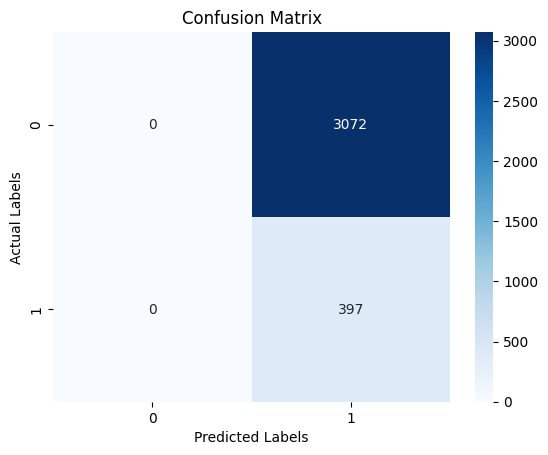

In [35]:
# plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

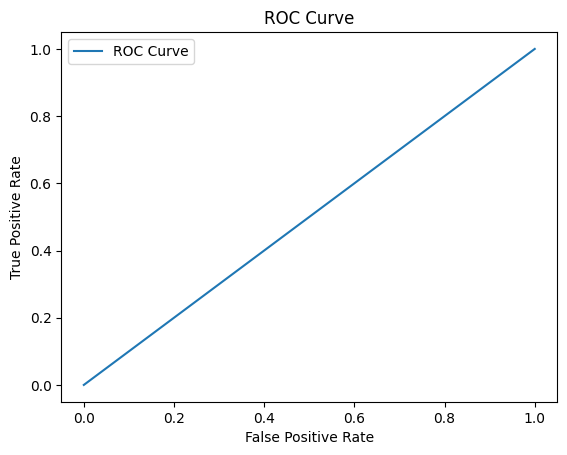

In [36]:
# plot the ROC AUC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(actual_labels, predicted_labels)

plt.plot(fpr, tpr, label='ROC Curve')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.show()

In [37]:
# find the mAp score
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(actual_labels, predicted_labels)

print(f"Average Precision Score: {average_precision:.2f}")

Average Precision Score: 0.11
